In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-23 00:21:58.237801
thunder  Mon Dec 23 00:21:58 2019
[0] GeForce GTX 1080 Ti | 41'C,   0 % |    10 / 11178 MB |
[1] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 46'C,   0 % | 10895 / 11178 MB | patra(10885M)
[3] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 44'C,   0 % | 10895 / 11178 MB | patra(10885M)
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Mon Dec 23 00:22:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   41C    P0    59W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   26C    P8     7W / 250W |     10Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "3"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [17]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [18]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [19]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=500
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [20]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/500
50/50 [==============================] - 24s 473ms/step - loss: 0.7152 - Accuracy: 0.5681 - Precision: 0.5790 - Recall: 0.6070 - F1: 0.5840 - AUC: 0.6035 - val_loss: 0.3377 - val_Accuracy: 0.9531 - val_Precision: 0.1000 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.5975
Epoch 2/500
50/50 [==============================] - 21s 427ms/step - loss: 0.6551 - Accuracy: 0.6294 - Precision: 0.6232 - Recall: 0.6359 - F1: 0.6205 - AUC: 0.6766 - val_loss: 0.6389 - val_Accuracy: 0.6438 - val_Precision: 0.0449 - val_Recall: 0.3667 - val_F1: 0.0789 - val_AUC: 0.6300
Epoch 3/500
50/50 [==============================] - 23s 458ms/step - loss: 0.6550 - Accuracy: 0.6313 - Precision: 0.6392 - Recall: 0.6284 - F1: 0.6262 - AUC: 0.6827 - val_loss: 0.7626 - val_Accuracy: 0.4000 - val_Precision: 0.0168 - val_Recall: 0.3000 - val_F1: 0.0317 - val_AUC: 0.5107
Epoch 4/500
50/50 [==============================] - 24s 484ms/step - loss: 0.6537 - Accuracy: 0.6313 - Precision: 0.6321 - Recall: 0.66

50/50 [==============================] - 23s 461ms/step - loss: 0.5317 - Accuracy: 0.7306 - Precision: 0.7583 - Recall: 0.7322 - F1: 0.7397 - AUC: 0.8166 - val_loss: 0.3595 - val_Accuracy: 0.9625 - val_Precision: 0.0500 - val_Recall: 0.1000 - val_F1: 0.0667 - val_AUC: 0.7696
Epoch 29/500
50/50 [==============================] - 23s 458ms/step - loss: 0.5449 - Accuracy: 0.7175 - Precision: 0.7173 - Recall: 0.7390 - F1: 0.7220 - AUC: 0.7983 - val_loss: 0.3854 - val_Accuracy: 0.9438 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6028
Epoch 30/500
50/50 [==============================] - 23s 466ms/step - loss: 0.5559 - Accuracy: 0.7206 - Precision: 0.7258 - Recall: 0.7417 - F1: 0.7269 - AUC: 0.7883 - val_loss: 0.3553 - val_Accuracy: 0.9531 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4183
Epoch 31/500
50/50 [==============================] - 23s 462ms/step - loss: 0.5402 - Accuracy: 0.7250 - Precision: 0.7344

Epoch 56/500
50/50 [==============================] - 25s 490ms/step - loss: 0.5418 - Accuracy: 0.7256 - Precision: 0.7332 - Recall: 0.7380 - F1: 0.7283 - AUC: 0.8023 - val_loss: 0.3602 - val_Accuracy: 0.9156 - val_Precision: 0.1250 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.7527
Epoch 57/500
50/50 [==============================] - 24s 484ms/step - loss: 0.5318 - Accuracy: 0.7381 - Precision: 0.7281 - Recall: 0.7740 - F1: 0.7452 - AUC: 0.8137 - val_loss: 0.3651 - val_Accuracy: 0.9156 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5345
Epoch 58/500
50/50 [==============================] - 24s 480ms/step - loss: 0.5307 - Accuracy: 0.7319 - Precision: 0.7174 - Recall: 0.7712 - F1: 0.7366 - AUC: 0.8121 - val_loss: 0.4557 - val_Accuracy: 0.8906 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4048
Epoch 59/500
50/50 [==============================] - 24s 487ms/step - loss: 0.5258 - Accuracy: 0.7356 - Prec

Epoch 84/500
50/50 [==============================] - 24s 481ms/step - loss: 0.5473 - Accuracy: 0.7287 - Precision: 0.7109 - Recall: 0.7584 - F1: 0.7241 - AUC: 0.8012 - val_loss: 0.3867 - val_Accuracy: 0.9312 - val_Precision: 0.0833 - val_Recall: 0.1500 - val_F1: 0.1000 - val_AUC: 0.6506
Epoch 85/500
50/50 [==============================] - 24s 472ms/step - loss: 0.5521 - Accuracy: 0.7275 - Precision: 0.7213 - Recall: 0.7485 - F1: 0.7281 - AUC: 0.7964 - val_loss: 0.3724 - val_Accuracy: 0.9125 - val_Precision: 0.0250 - val_Recall: 0.1000 - val_F1: 0.0400 - val_AUC: 0.6276
Epoch 86/500
50/50 [==============================] - 24s 477ms/step - loss: 0.5547 - Accuracy: 0.7131 - Precision: 0.7080 - Recall: 0.7427 - F1: 0.7155 - AUC: 0.7861 - val_loss: 0.3743 - val_Accuracy: 0.9125 - val_Precision: 0.1500 - val_Recall: 0.1500 - val_F1: 0.1333 - val_AUC: 0.6637
Epoch 87/500
50/50 [==============================] - 24s 475ms/step - loss: 0.5415 - Accuracy: 0.7331 - Precision: 0.7444 - Recall: 

50/50 [==============================] - 24s 473ms/step - loss: 0.5450 - Accuracy: 0.7194 - Precision: 0.7162 - Recall: 0.7450 - F1: 0.7247 - AUC: 0.7966 - val_loss: 0.4014 - val_Accuracy: 0.9250 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6456
Epoch 113/500
50/50 [==============================] - 24s 470ms/step - loss: 0.5286 - Accuracy: 0.7344 - Precision: 0.7214 - Recall: 0.7657 - F1: 0.7340 - AUC: 0.8170 - val_loss: 0.4180 - val_Accuracy: 0.9187 - val_Precision: 0.0333 - val_Recall: 0.0250 - val_F1: 0.0286 - val_AUC: 0.5971
Epoch 114/500
50/50 [==============================] - 24s 478ms/step - loss: 0.5481 - Accuracy: 0.7237 - Precision: 0.7230 - Recall: 0.7472 - F1: 0.7278 - AUC: 0.7968 - val_loss: 0.3790 - val_Accuracy: 0.9406 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6556
Epoch 115/500
50/50 [==============================] - 23s 462ms/step - loss: 0.5395 - Accuracy: 0.7325 - Precision: 0.7

Epoch 140/500
50/50 [==============================] - 23s 468ms/step - loss: 0.5320 - Accuracy: 0.7387 - Precision: 0.7263 - Recall: 0.7748 - F1: 0.7427 - AUC: 0.8128 - val_loss: 0.4601 - val_Accuracy: 0.9062 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4979
Epoch 141/500
50/50 [==============================] - 24s 479ms/step - loss: 0.5248 - Accuracy: 0.7387 - Precision: 0.7113 - Recall: 0.7880 - F1: 0.7400 - AUC: 0.8209 - val_loss: 0.3730 - val_Accuracy: 0.9500 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7460
Epoch 142/500
50/50 [==============================] - 24s 482ms/step - loss: 0.5352 - Accuracy: 0.7356 - Precision: 0.7384 - Recall: 0.7494 - F1: 0.7358 - AUC: 0.8088 - val_loss: 0.3237 - val_Accuracy: 0.9375 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6214
Epoch 143/500
50/50 [==============================] - 24s 473ms/step - loss: 0.5422 - Accurac

50/50 [==============================] - 24s 480ms/step - loss: 0.5300 - Accuracy: 0.7381 - Precision: 0.7166 - Recall: 0.7653 - F1: 0.7338 - AUC: 0.8130 - val_loss: 0.3632 - val_Accuracy: 0.9219 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5572
Epoch 168/500
50/50 [==============================] - 24s 473ms/step - loss: 0.5322 - Accuracy: 0.7300 - Precision: 0.7160 - Recall: 0.7530 - F1: 0.7239 - AUC: 0.8128 - val_loss: 0.3632 - val_Accuracy: 0.9438 - val_Precision: 0.1000 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.5663
Epoch 169/500
50/50 [==============================] - 24s 483ms/step - loss: 0.5362 - Accuracy: 0.7356 - Precision: 0.7479 - Recall: 0.7493 - F1: 0.7419 - AUC: 0.8081 - val_loss: 0.3329 - val_Accuracy: 0.9469 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5407
Epoch 170/500
50/50 [==============================] - 24s 480ms/step - loss: 0.5310 - Accuracy: 0.7394 - Precision: 0.7

Epoch 195/500
50/50 [==============================] - 24s 476ms/step - loss: 0.5282 - Accuracy: 0.7456 - Precision: 0.7381 - Recall: 0.7614 - F1: 0.7426 - AUC: 0.8183 - val_loss: 0.3985 - val_Accuracy: 0.9281 - val_Precision: 0.0167 - val_Recall: 0.0500 - val_F1: 0.0250 - val_AUC: 0.5868
Epoch 196/500
50/50 [==============================] - 24s 476ms/step - loss: 0.5227 - Accuracy: 0.7487 - Precision: 0.7451 - Recall: 0.7604 - F1: 0.7486 - AUC: 0.8242 - val_loss: 0.3739 - val_Accuracy: 0.9187 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6472
Epoch 197/500
50/50 [==============================] - 24s 482ms/step - loss: 0.5212 - Accuracy: 0.7362 - Precision: 0.7379 - Recall: 0.7531 - F1: 0.7378 - AUC: 0.8228 - val_loss: 0.3927 - val_Accuracy: 0.9406 - val_Precision: 0.1000 - val_Recall: 0.2000 - val_F1: 0.1333 - val_AUC: 0.7040
Epoch 198/500
50/50 [==============================] - 24s 484ms/step - loss: 0.5200 - Accuracy: 0.7350 - Precision: 0

Epoch 223/500
50/50 [==============================] - 24s 480ms/step - loss: 0.5484 - Accuracy: 0.7119 - Precision: 0.6913 - Recall: 0.7440 - F1: 0.7100 - AUC: 0.7915 - val_loss: 0.4540 - val_Accuracy: 0.9125 - val_Precision: 0.0500 - val_Recall: 0.0500 - val_F1: 0.0500 - val_AUC: 0.6645
Epoch 224/500
50/50 [==============================] - 24s 482ms/step - loss: 0.5330 - Accuracy: 0.7513 - Precision: 0.7535 - Recall: 0.7814 - F1: 0.7605 - AUC: 0.8171 - val_loss: 0.3989 - val_Accuracy: 0.9312 - val_Precision: 0.0833 - val_Recall: 0.2000 - val_F1: 0.1167 - val_AUC: 0.6893
Epoch 225/500
50/50 [==============================] - 24s 485ms/step - loss: 0.5420 - Accuracy: 0.7237 - Precision: 0.7383 - Recall: 0.7377 - F1: 0.7293 - AUC: 0.8018 - val_loss: 0.3443 - val_Accuracy: 0.9375 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6151
Epoch 226/500
50/50 [==============================] - 24s 487ms/step - loss: 0.5398 - Accuracy: 0.7362 - Precision: 0

Epoch 251/500
50/50 [==============================] - 24s 474ms/step - loss: 0.5377 - Accuracy: 0.7306 - Precision: 0.7392 - Recall: 0.7506 - F1: 0.7404 - AUC: 0.8064 - val_loss: 0.4064 - val_Accuracy: 0.8719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4205
Epoch 252/500
50/50 [==============================] - 24s 470ms/step - loss: 0.5281 - Accuracy: 0.7506 - Precision: 0.7502 - Recall: 0.7665 - F1: 0.7535 - AUC: 0.8190 - val_loss: 0.4312 - val_Accuracy: 0.8750 - val_Precision: 0.0400 - val_Recall: 0.1500 - val_F1: 0.0619 - val_AUC: 0.6088
Epoch 253/500
50/50 [==============================] - 24s 477ms/step - loss: 0.5296 - Accuracy: 0.7344 - Precision: 0.7432 - Recall: 0.7548 - F1: 0.7411 - AUC: 0.8145 - val_loss: 0.4247 - val_Accuracy: 0.9187 - val_Precision: 0.0333 - val_Recall: 0.1000 - val_F1: 0.0500 - val_AUC: 0.7542
Epoch 254/500
50/50 [==============================] - 24s 471ms/step - loss: 0.5114 - Accuracy: 0.7544 - Precision: 0

Epoch 279/500
50/50 [==============================] - 23s 462ms/step - loss: 0.5320 - Accuracy: 0.7444 - Precision: 0.7512 - Recall: 0.7713 - F1: 0.7532 - AUC: 0.8132 - val_loss: 0.4199 - val_Accuracy: 0.9062 - val_Precision: 0.0143 - val_Recall: 0.0500 - val_F1: 0.0222 - val_AUC: 0.4481
Epoch 280/500
50/50 [==============================] - 24s 472ms/step - loss: 0.5383 - Accuracy: 0.7250 - Precision: 0.6913 - Recall: 0.7870 - F1: 0.7278 - AUC: 0.8078 - val_loss: 0.4249 - val_Accuracy: 0.8969 - val_Precision: 0.0333 - val_Recall: 0.1000 - val_F1: 0.0500 - val_AUC: 0.6127
Epoch 281/500
50/50 [==============================] - 23s 464ms/step - loss: 0.5357 - Accuracy: 0.7344 - Precision: 0.7319 - Recall: 0.7599 - F1: 0.7395 - AUC: 0.8085 - val_loss: 0.3622 - val_Accuracy: 0.9219 - val_Precision: 0.0583 - val_Recall: 0.0700 - val_F1: 0.0583 - val_AUC: 0.5781
Epoch 282/500
50/50 [==============================] - 23s 462ms/step - loss: 0.5337 - Accuracy: 0.7300 - Precision: 0.7131 - Reca

Epoch 307/500
50/50 [==============================] - 24s 481ms/step - loss: 0.5100 - Accuracy: 0.7544 - Precision: 0.7321 - Recall: 0.7912 - F1: 0.7545 - AUC: 0.8350 - val_loss: 0.3832 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7335
Epoch 308/500
50/50 [==============================] - 24s 482ms/step - loss: 0.5274 - Accuracy: 0.7519 - Precision: 0.7708 - Recall: 0.7565 - F1: 0.7573 - AUC: 0.8174 - val_loss: 0.3922 - val_Accuracy: 0.9469 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7066
Epoch 309/500
50/50 [==============================] - 24s 474ms/step - loss: 0.5249 - Accuracy: 0.7287 - Precision: 0.7296 - Recall: 0.7536 - F1: 0.7346 - AUC: 0.8164 - val_loss: 0.4094 - val_Accuracy: 0.9312 - val_Precision: 0.0250 - val_Recall: 0.0500 - val_F1: 0.0333 - val_AUC: 0.5418
Epoch 310/500
50/50 [==============================] - 23s 463ms/step - loss: 0.5302 - Accuracy: 0.7387 - 

Epoch 335/500
50/50 [==============================] - 24s 482ms/step - loss: 0.5410 - Accuracy: 0.7219 - Precision: 0.6959 - Recall: 0.7460 - F1: 0.7152 - AUC: 0.8036 - val_loss: 0.4025 - val_Accuracy: 0.9219 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4609
Epoch 336/500
50/50 [==============================] - 24s 477ms/step - loss: 0.5252 - Accuracy: 0.7416 - Precision: 0.7341 - Recall: 0.7540 - F1: 0.7387 - AUC: 0.8194 - val_loss: 0.4092 - val_Accuracy: 0.9281 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.9025
Epoch 337/500
50/50 [==============================] - 24s 471ms/step - loss: 0.5397 - Accuracy: 0.7356 - Precision: 0.7219 - Recall: 0.7652 - F1: 0.7324 - AUC: 0.8025 - val_loss: 0.3352 - val_Accuracy: 0.9438 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5925
Epoch 338/500
50/50 [==============================] - 24s 472ms/step - loss: 0.5213 - Accurac

Epoch 363/500
50/50 [==============================] - 23s 464ms/step - loss: 0.5192 - Accuracy: 0.7419 - Precision: 0.7359 - Recall: 0.7648 - F1: 0.7433 - AUC: 0.8239 - val_loss: 0.3244 - val_Accuracy: 0.9250 - val_Precision: 0.0167 - val_Recall: 0.1000 - val_F1: 0.0286 - val_AUC: 0.7705
Epoch 364/500
50/50 [==============================] - 24s 471ms/step - loss: 0.5285 - Accuracy: 0.7456 - Precision: 0.7480 - Recall: 0.7697 - F1: 0.7528 - AUC: 0.8132 - val_loss: 0.4100 - val_Accuracy: 0.9000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5441
Epoch 365/500
50/50 [==============================] - 23s 461ms/step - loss: 0.5303 - Accuracy: 0.7306 - Precision: 0.7315 - Recall: 0.7561 - F1: 0.7370 - AUC: 0.8132 - val_loss: 0.3704 - val_Accuracy: 0.9312 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4854
Epoch 366/500
50/50 [==============================] - 23s 470ms/step - loss: 0.5297 - Accuracy: 0.7306 - 

Epoch 391/500
50/50 [==============================] - 24s 478ms/step - loss: 0.5261 - Accuracy: 0.7456 - Precision: 0.7529 - Recall: 0.7700 - F1: 0.7540 - AUC: 0.8200 - val_loss: 0.4876 - val_Accuracy: 0.9094 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5889
Epoch 392/500
50/50 [==============================] - 24s 478ms/step - loss: 0.5107 - Accuracy: 0.7506 - Precision: 0.7332 - Recall: 0.7897 - F1: 0.7536 - AUC: 0.8349 - val_loss: 0.4238 - val_Accuracy: 0.9281 - val_Precision: 0.0333 - val_Recall: 0.1000 - val_F1: 0.0500 - val_AUC: 0.5746
Epoch 393/500
50/50 [==============================] - 24s 475ms/step - loss: 0.5270 - Accuracy: 0.7494 - Precision: 0.7422 - Recall: 0.7715 - F1: 0.7509 - AUC: 0.8174 - val_loss: 0.3439 - val_Accuracy: 0.9281 - val_Precision: 0.0533 - val_Recall: 0.0833 - val_F1: 0.0650 - val_AUC: 0.6388
Epoch 394/500
50/50 [==============================] - 24s 475ms/step - loss: 0.5425 - Accuracy: 0.7275 - Precision: 0

Epoch 419/500
50/50 [==============================] - 24s 480ms/step - loss: 0.5169 - Accuracy: 0.7569 - Precision: 0.7631 - Recall: 0.7778 - F1: 0.7640 - AUC: 0.8296 - val_loss: 0.3816 - val_Accuracy: 0.9187 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5543
Epoch 420/500
50/50 [==============================] - 24s 483ms/step - loss: 0.5207 - Accuracy: 0.7494 - Precision: 0.7511 - Recall: 0.7608 - F1: 0.7510 - AUC: 0.8247 - val_loss: 0.3494 - val_Accuracy: 0.9125 - val_Precision: 0.0250 - val_Recall: 0.0500 - val_F1: 0.0333 - val_AUC: 0.6269
Epoch 421/500
50/50 [==============================] - 24s 484ms/step - loss: 0.5211 - Accuracy: 0.7481 - Precision: 0.7510 - Recall: 0.7689 - F1: 0.7547 - AUC: 0.8215 - val_loss: 0.3887 - val_Accuracy: 0.9156 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5801
Epoch 422/500
50/50 [==============================] - 24s 481ms/step - loss: 0.5307 - Accuracy: 0.7369 - 

Epoch 447/500
50/50 [==============================] - 25s 492ms/step - loss: 0.5222 - Accuracy: 0.7475 - Precision: 0.7406 - Recall: 0.7716 - F1: 0.7516 - AUC: 0.8212 - val_loss: 0.4178 - val_Accuracy: 0.9062 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6149
Epoch 448/500
50/50 [==============================] - 24s 483ms/step - loss: 0.5107 - Accuracy: 0.7575 - Precision: 0.7506 - Recall: 0.7851 - F1: 0.7607 - AUC: 0.8334 - val_loss: 0.4107 - val_Accuracy: 0.9312 - val_Precision: 0.0333 - val_Recall: 0.1000 - val_F1: 0.0500 - val_AUC: 0.6743
Epoch 449/500
50/50 [==============================] - 25s 490ms/step - loss: 0.5068 - Accuracy: 0.7525 - Precision: 0.7266 - Recall: 0.7895 - F1: 0.7494 - AUC: 0.8362 - val_loss: 0.3791 - val_Accuracy: 0.9187 - val_Precision: 0.0167 - val_Recall: 0.0333 - val_F1: 0.0222 - val_AUC: 0.6038
Epoch 450/500
50/50 [==============================] - 25s 492ms/step - loss: 0.5118 - Accuracy: 0.7500 - Precision: 0

Epoch 475/500
50/50 [==============================] - 24s 489ms/step - loss: 0.5233 - Accuracy: 0.7425 - Precision: 0.7489 - Recall: 0.7626 - F1: 0.7500 - AUC: 0.8199 - val_loss: 0.4151 - val_Accuracy: 0.9250 - val_Precision: 0.1250 - val_Recall: 0.1500 - val_F1: 0.1333 - val_AUC: 0.6476
Epoch 476/500
50/50 [==============================] - 24s 484ms/step - loss: 0.5137 - Accuracy: 0.7538 - Precision: 0.7440 - Recall: 0.7881 - F1: 0.7598 - AUC: 0.8285 - val_loss: 0.3777 - val_Accuracy: 0.9000 - val_Precision: 0.0200 - val_Recall: 0.0500 - val_F1: 0.0286 - val_AUC: 0.6745
Epoch 477/500
50/50 [==============================] - 24s 490ms/step - loss: 0.5273 - Accuracy: 0.7381 - Precision: 0.7301 - Recall: 0.7593 - F1: 0.7387 - AUC: 0.8165 - val_loss: 0.3942 - val_Accuracy: 0.9187 - val_Precision: 0.0500 - val_Recall: 0.1000 - val_F1: 0.0667 - val_AUC: 0.5745
Epoch 478/500
50/50 [==============================] - 25s 501ms/step - loss: 0.5246 - Accuracy: 0.7406 - Precision: 0.7269 - Reca

In [21]:
print("Time taken:",end-start)

Time taken: 11913.086498975754


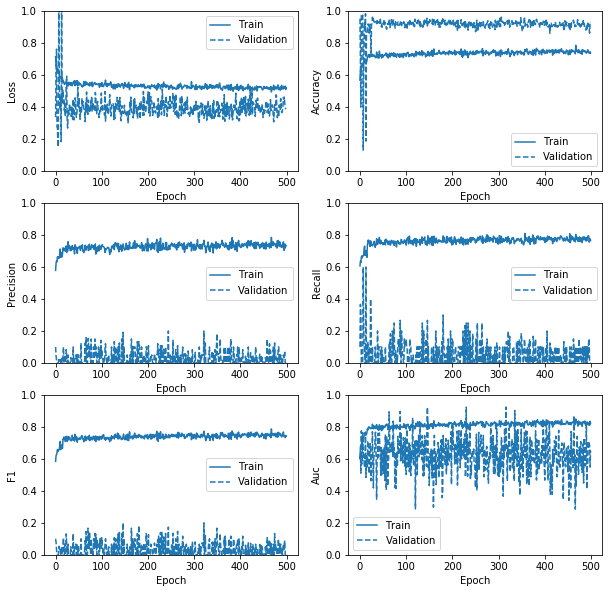

In [22]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [23]:
# start = time.time()
# up2_history = model.fit_generator(up2_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [1.5,0.5],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [24]:
# print("Time taken:",end-start)

In [25]:
# plt.figure(figsize=(10,10))
# plot_metrics(up2_history)

### Train with UP3 (1:20)

In [26]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              class_weight = {0:0.5,1:3},
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/500
50/50 [==============================] - 22s 439ms/step - loss: 0.3981 - Accuracy: 0.5562 - Precision: 0.0883 - Recall: 0.7317 - F1: 0.1522 - AUC: 0.8361 - val_loss: 0.4348 - val_Accuracy: 0.9000 - val_Precision: 0.1150 - val_Recall: 0.3500 - val_F1: 0.1667 - val_AUC: 0.8763
Epoch 2/500
50/50 [==============================] - 20s 397ms/step - loss: 0.3848 - Accuracy: 0.5825 - Precision: 0.0951 - Recall: 0.7360 - F1: 0.1628 - AUC: 0.8615 - val_loss: 0.4112 - val_Accuracy: 0.8531 - val_Precision: 0.0458 - val_Recall: 0.0833 - val_F1: 0.0582 - val_AUC: 0.6480
Epoch 3/500
50/50 [==============================] - 21s 414ms/step - loss: 0.3895 - Accuracy: 0.5919 - Precision: 0.0976 - Recall: 0.6467 - F1: 0.1661 - AUC: 0.8144 - val_loss: 0.4511 - val_Accuracy: 0.8844 - val_Precision: 0.0500 - val_Recall: 0.1000 - val_F1: 0.0667 - val_AUC: 0.5112
Epoch 4/500
50/50 [==============================] - 20s 405ms/step - loss: 0.3765 - Accuracy: 0.6062 - Precision: 0.0872 - Recall: 0.71

Epoch 29/500
50/50 [==============================] - 18s 350ms/step - loss: 0.3025 - Accuracy: 0.8175 - Precision: 0.1277 - Recall: 0.4317 - F1: 0.1843 - AUC: 0.7661 - val_loss: 0.3966 - val_Accuracy: 0.9563 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4372
Epoch 30/500
50/50 [==============================] - 18s 354ms/step - loss: 0.2913 - Accuracy: 0.8138 - Precision: 0.1464 - Recall: 0.4333 - F1: 0.2095 - AUC: 0.8232 - val_loss: 0.3776 - val_Accuracy: 0.9375 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5102
Epoch 31/500
50/50 [==============================] - 19s 384ms/step - loss: 0.3040 - Accuracy: 0.8344 - Precision: 0.1679 - Recall: 0.4230 - F1: 0.2258 - AUC: 0.8128 - val_loss: 0.3388 - val_Accuracy: 0.9438 - val_Precision: 0.0500 - val_Recall: 0.1000 - val_F1: 0.0667 - val_AUC: 0.7274
Epoch 32/500
50/50 [==============================] - 19s 379ms/step - loss: 0.2959 - Accuracy: 0.8338 - Prec

50/50 [==============================] - 18s 362ms/step - loss: 0.2715 - Accuracy: 0.8900 - Precision: 0.1339 - Recall: 0.2483 - F1: 0.1654 - AUC: 0.8174 - val_loss: 0.4455 - val_Accuracy: 0.9469 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5082
Epoch 57/500
50/50 [==============================] - 19s 370ms/step - loss: 0.2576 - Accuracy: 0.9000 - Precision: 0.2487 - Recall: 0.4430 - F1: 0.2871 - AUC: 0.8332 - val_loss: 0.3227 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7047
Epoch 58/500
50/50 [==============================] - 20s 405ms/step - loss: 0.2667 - Accuracy: 0.9112 - Precision: 0.2804 - Recall: 0.4367 - F1: 0.3107 - AUC: 0.8476 - val_loss: 0.2487 - val_Accuracy: 0.9563 - val_Precision: 0.1000 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.5713
Epoch 59/500
50/50 [==============================] - 18s 353ms/step - loss: 0.2529 - Accuracy: 0.9031 - Precision: 0.2210

50/50 [==============================] - 16s 325ms/step - loss: 0.2967 - Accuracy: 0.9119 - Precision: 0.2600 - Recall: 0.2833 - F1: 0.2543 - AUC: 0.8290 - val_loss: 0.2129 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7723
Epoch 84/500
50/50 [==============================] - 16s 319ms/step - loss: 0.2834 - Accuracy: 0.9144 - Precision: 0.2067 - Recall: 0.2250 - F1: 0.1940 - AUC: 0.8108 - val_loss: 0.3970 - val_Accuracy: 0.9531 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5192
Epoch 85/500
50/50 [==============================] - 18s 365ms/step - loss: 0.2753 - Accuracy: 0.9156 - Precision: 0.2650 - Recall: 0.3200 - F1: 0.2543 - AUC: 0.8265 - val_loss: 0.2185 - val_Accuracy: 0.9750 - val_Precision: 0.1000 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.6218
Epoch 86/500
50/50 [==============================] - 20s 397ms/step - loss: 0.2466 - Accuracy: 0.9300 - Precision: 0.3300

50/50 [==============================] - 15s 301ms/step - loss: 0.2373 - Accuracy: 0.9250 - Precision: 0.2040 - Recall: 0.2080 - F1: 0.1892 - AUC: 0.8640 - val_loss: 0.2308 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6639
Epoch 111/500
50/50 [==============================] - 18s 363ms/step - loss: 0.2201 - Accuracy: 0.9362 - Precision: 0.2480 - Recall: 0.2633 - F1: 0.2441 - AUC: 0.8383 - val_loss: 0.2381 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6735
Epoch 112/500
50/50 [==============================] - 17s 345ms/step - loss: 0.2284 - Accuracy: 0.9231 - Precision: 0.1893 - Recall: 0.2333 - F1: 0.1895 - AUC: 0.8635 - val_loss: 0.2054 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5924
Epoch 113/500
50/50 [==============================] - 15s 294ms/step - loss: 0.2662 - Accuracy: 0.9212 - Pr

50/50 [==============================] - 20s 393ms/step - loss: 0.2717 - Accuracy: 0.9250 - Precision: 0.2897 - Recall: 0.2657 - F1: 0.2477 - AUC: 0.8239 - val_loss: 0.2569 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5857
Epoch 138/500
50/50 [==============================] - 20s 402ms/step - loss: 0.2516 - Accuracy: 0.9344 - Precision: 0.2333 - Recall: 0.2317 - F1: 0.2187 - AUC: 0.8098 - val_loss: 0.2643 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4729
Epoch 139/500
50/50 [==============================] - 20s 395ms/step - loss: 0.2692 - Accuracy: 0.9275 - Precision: 0.2367 - Recall: 0.2340 - F1: 0.2177 - AUC: 0.8323 - val_loss: 0.1854 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5452
Epoch 140/500
50/50 [==============================] - 20s 394ms/step - loss: 0.2670 - Accuracy: 0.9337 - Pr

50/50 [==============================] - 16s 311ms/step - loss: 0.2390 - Accuracy: 0.9356 - Precision: 0.1970 - Recall: 0.1983 - F1: 0.1770 - AUC: 0.8526 - val_loss: 0.2574 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6647
Epoch 165/500
50/50 [==============================] - 16s 315ms/step - loss: 0.2403 - Accuracy: 0.9369 - Precision: 0.2087 - Recall: 0.2487 - F1: 0.2207 - AUC: 0.8489 - val_loss: 0.2355 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4735
Epoch 166/500
50/50 [==============================] - 19s 388ms/step - loss: 0.2568 - Accuracy: 0.9225 - Precision: 0.2047 - Recall: 0.2130 - F1: 0.1855 - AUC: 0.8404 - val_loss: 0.3494 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4701
Epoch 167/500
50/50 [==============================] - 20s 392ms/step - loss: 0.2542 - Accuracy: 0.9281 - Pr

50/50 [==============================] - 15s 294ms/step - loss: 0.2464 - Accuracy: 0.9337 - Precision: 0.2413 - Recall: 0.3067 - F1: 0.2425 - AUC: 0.8276 - val_loss: 0.2421 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6156
Epoch 192/500
50/50 [==============================] - 15s 299ms/step - loss: 0.2599 - Accuracy: 0.9337 - Precision: 0.2433 - Recall: 0.2047 - F1: 0.2036 - AUC: 0.8225 - val_loss: 0.2075 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6815
Epoch 193/500
50/50 [==============================] - 16s 313ms/step - loss: 0.2359 - Accuracy: 0.9325 - Precision: 0.1717 - Recall: 0.1807 - F1: 0.1548 - AUC: 0.8372 - val_loss: 0.1652 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4106
Epoch 194/500
50/50 [==============================] - 18s 350ms/step - loss: 0.2475 - Accuracy: 0.9344 - Pr

50/50 [==============================] - 15s 310ms/step - loss: 0.2962 - Accuracy: 0.9212 - Precision: 0.2170 - Recall: 0.2340 - F1: 0.2050 - AUC: 0.8191 - val_loss: 0.1888 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5675
Epoch 219/500
50/50 [==============================] - 17s 332ms/step - loss: 0.2512 - Accuracy: 0.9275 - Precision: 0.2117 - Recall: 0.1777 - F1: 0.1715 - AUC: 0.8398 - val_loss: 0.2324 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7040
Epoch 220/500
50/50 [==============================] - 16s 314ms/step - loss: 0.2661 - Accuracy: 0.9319 - Precision: 0.3100 - Recall: 0.3320 - F1: 0.2875 - AUC: 0.8439 - val_loss: 0.2247 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6434
Epoch 221/500
50/50 [==============================] - 17s 335ms/step - loss: 0.2294 - Accuracy: 0.9463 - Pr

50/50 [==============================] - 14s 290ms/step - loss: 0.2297 - Accuracy: 0.9375 - Precision: 0.1333 - Recall: 0.2100 - F1: 0.1580 - AUC: 0.7607 - val_loss: 0.2988 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4575
Epoch 246/500
50/50 [==============================] - 15s 291ms/step - loss: 0.2170 - Accuracy: 0.9419 - Precision: 0.1983 - Recall: 0.2070 - F1: 0.1781 - AUC: 0.8254 - val_loss: 0.2575 - val_Accuracy: 0.9500 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5766
Epoch 247/500
50/50 [==============================] - 15s 308ms/step - loss: 0.2676 - Accuracy: 0.9319 - Precision: 0.2600 - Recall: 0.1850 - F1: 0.1907 - AUC: 0.8127 - val_loss: 0.1885 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7763
Epoch 248/500
50/50 [==============================] - 16s 329ms/step - loss: 0.2621 - Accuracy: 0.9312 - Pr

50/50 [==============================] - 18s 353ms/step - loss: 0.2868 - Accuracy: 0.9187 - Precision: 0.2650 - Recall: 0.2817 - F1: 0.2447 - AUC: 0.8189 - val_loss: 0.1940 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5787
Epoch 273/500
50/50 [==============================] - 19s 385ms/step - loss: 0.2604 - Accuracy: 0.9362 - Precision: 0.2573 - Recall: 0.2780 - F1: 0.2373 - AUC: 0.8428 - val_loss: 0.1772 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7797
Epoch 274/500
50/50 [==============================] - 18s 368ms/step - loss: 0.2650 - Accuracy: 0.9275 - Precision: 0.2970 - Recall: 0.2870 - F1: 0.2615 - AUC: 0.8548 - val_loss: 0.2316 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4407
Epoch 275/500
50/50 [==============================] - 16s 327ms/step - loss: 0.2558 - Accuracy: 0.9231 - Pr

50/50 [==============================] - 17s 347ms/step - loss: 0.2877 - Accuracy: 0.9312 - Precision: 0.3000 - Recall: 0.2770 - F1: 0.2619 - AUC: 0.8031 - val_loss: 0.2096 - val_Accuracy: 0.9563 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5594
Epoch 300/500
50/50 [==============================] - 14s 287ms/step - loss: 0.2316 - Accuracy: 0.9369 - Precision: 0.2417 - Recall: 0.1783 - F1: 0.1950 - AUC: 0.8223 - val_loss: 0.2200 - val_Accuracy: 0.9906 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5594
Epoch 301/500
50/50 [==============================] - 17s 346ms/step - loss: 0.2371 - Accuracy: 0.9362 - Precision: 0.2183 - Recall: 0.2450 - F1: 0.1998 - AUC: 0.8395 - val_loss: 0.2009 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6009
Epoch 302/500
50/50 [==============================] - 15s 304ms/step - loss: 0.2588 - Accuracy: 0.9362 - Pr

50/50 [==============================] - 15s 306ms/step - loss: 0.2675 - Accuracy: 0.9312 - Precision: 0.2623 - Recall: 0.2750 - F1: 0.2405 - AUC: 0.8224 - val_loss: 0.2155 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6488
Epoch 327/500
50/50 [==============================] - 20s 394ms/step - loss: 0.2575 - Accuracy: 0.9231 - Precision: 0.1717 - Recall: 0.1900 - F1: 0.1590 - AUC: 0.7892 - val_loss: 0.1926 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5757
Epoch 328/500
50/50 [==============================] - 21s 429ms/step - loss: 0.2509 - Accuracy: 0.9369 - Precision: 0.3200 - Recall: 0.3267 - F1: 0.3000 - AUC: 0.8487 - val_loss: 0.1642 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.8134
Epoch 329/500
50/50 [==============================] - 19s 382ms/step - loss: 0.2603 - Accuracy: 0.9269 - Pr

50/50 [==============================] - 15s 310ms/step - loss: 0.2360 - Accuracy: 0.9400 - Precision: 0.2880 - Recall: 0.3187 - F1: 0.2748 - AUC: 0.8623 - val_loss: 0.1893 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5850
Epoch 354/500
50/50 [==============================] - 15s 306ms/step - loss: 0.2331 - Accuracy: 0.9388 - Precision: 0.1950 - Recall: 0.2100 - F1: 0.1845 - AUC: 0.8243 - val_loss: 0.1878 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6343
Epoch 355/500
50/50 [==============================] - 16s 325ms/step - loss: 0.2422 - Accuracy: 0.9344 - Precision: 0.3167 - Recall: 0.3300 - F1: 0.2955 - AUC: 0.8547 - val_loss: 0.1927 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6998
Epoch 356/500
50/50 [==============================] - 17s 335ms/step - loss: 0.2709 - Accuracy: 0.9306 - Pr

50/50 [==============================] - 17s 347ms/step - loss: 0.2420 - Accuracy: 0.9231 - Precision: 0.2157 - Recall: 0.2050 - F1: 0.1787 - AUC: 0.8451 - val_loss: 0.3748 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4677
Epoch 381/500
50/50 [==============================] - 16s 315ms/step - loss: 0.2866 - Accuracy: 0.9256 - Precision: 0.2367 - Recall: 0.2397 - F1: 0.2116 - AUC: 0.8165 - val_loss: 0.1793 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7594
Epoch 382/500
50/50 [==============================] - 15s 309ms/step - loss: 0.2337 - Accuracy: 0.9337 - Precision: 0.2033 - Recall: 0.2373 - F1: 0.1968 - AUC: 0.8263 - val_loss: 0.2009 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7516
Epoch 383/500
50/50 [==============================] - 14s 285ms/step - loss: 0.2634 - Accuracy: 0.9275 - Pr

50/50 [==============================] - 16s 314ms/step - loss: 0.2423 - Accuracy: 0.9275 - Precision: 0.2017 - Recall: 0.1950 - F1: 0.1848 - AUC: 0.8347 - val_loss: 0.1783 - val_Accuracy: 0.9812 - val_Precision: 0.1000 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.6406
Epoch 408/500
50/50 [==============================] - 16s 320ms/step - loss: 0.2430 - Accuracy: 0.9325 - Precision: 0.2080 - Recall: 0.2417 - F1: 0.2018 - AUC: 0.8474 - val_loss: 0.2568 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5406
Epoch 409/500
50/50 [==============================] - 17s 334ms/step - loss: 0.2711 - Accuracy: 0.9194 - Precision: 0.2423 - Recall: 0.2457 - F1: 0.2204 - AUC: 0.8248 - val_loss: 0.3100 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5950
Epoch 410/500
50/50 [==============================] - 14s 286ms/step - loss: 0.2451 - Accuracy: 0.9312 - Precision: 0.2

50/50 [==============================] - 14s 282ms/step - loss: 0.2570 - Accuracy: 0.9262 - Precision: 0.2983 - Recall: 0.2773 - F1: 0.2633 - AUC: 0.8538 - val_loss: 0.1625 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7497
Epoch 435/500
50/50 [==============================] - 16s 328ms/step - loss: 0.2388 - Accuracy: 0.9269 - Precision: 0.1550 - Recall: 0.2450 - F1: 0.1761 - AUC: 0.7939 - val_loss: 0.1891 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6512
Epoch 436/500
50/50 [==============================] - 17s 349ms/step - loss: 0.2561 - Accuracy: 0.9306 - Precision: 0.2567 - Recall: 0.2733 - F1: 0.2507 - AUC: 0.8405 - val_loss: 0.1949 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6572
Epoch 437/500
50/50 [==============================] - 17s 333ms/step - loss: 0.2552 - Accuracy: 0.9212 - Pr

50/50 [==============================] - 20s 391ms/step - loss: 0.2600 - Accuracy: 0.9250 - Precision: 0.2333 - Recall: 0.1990 - F1: 0.1866 - AUC: 0.8472 - val_loss: 0.1548 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5361
Epoch 462/500
50/50 [==============================] - 14s 282ms/step - loss: 0.2356 - Accuracy: 0.9406 - Precision: 0.2520 - Recall: 0.2683 - F1: 0.2324 - AUC: 0.8281 - val_loss: 0.2904 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4106
Epoch 463/500
50/50 [==============================] - 16s 324ms/step - loss: 0.2588 - Accuracy: 0.9287 - Precision: 0.2400 - Recall: 0.2673 - F1: 0.2364 - AUC: 0.8489 - val_loss: 0.1933 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6835
Epoch 464/500
50/50 [==============================] - 16s 325ms/step - loss: 0.2775 - Accuracy: 0.9256 - Pr

50/50 [==============================] - 15s 300ms/step - loss: 0.2197 - Accuracy: 0.9400 - Precision: 0.1933 - Recall: 0.2833 - F1: 0.2154 - AUC: 0.8604 - val_loss: 0.1812 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6429
Epoch 489/500
50/50 [==============================] - 16s 321ms/step - loss: 0.2379 - Accuracy: 0.9331 - Precision: 0.2367 - Recall: 0.2023 - F1: 0.1975 - AUC: 0.8258 - val_loss: 0.1401 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6048
Epoch 490/500
50/50 [==============================] - 15s 297ms/step - loss: 0.2468 - Accuracy: 0.9300 - Precision: 0.2407 - Recall: 0.1967 - F1: 0.2017 - AUC: 0.8615 - val_loss: 0.1497 - val_Accuracy: 0.9969 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4342
Epoch 491/500
50/50 [==============================] - 17s 341ms/step - loss: 0.2582 - Accuracy: 0.9381 - Pr

In [27]:
print("Time taken:",end-start)

Time taken: 8470.479994535446


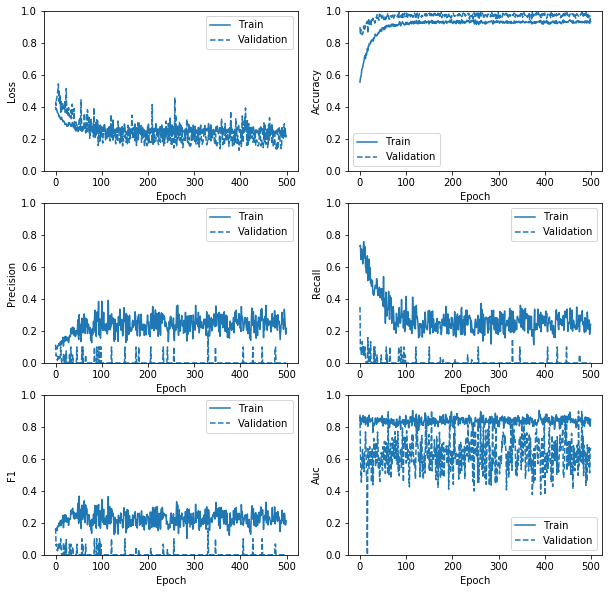

In [28]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [29]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [30]:
# print("Time taken:",end-start)

In [31]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [32]:
start = time.time()
imb_history = model.fit_generator(imb_train_generator,
                                  epochs=n_epochs,
                                  steps_per_epoch=n_steps_per_epoch,
                                  validation_data=validation_generator,
                                  validation_steps=n_validation_steps,
                                  class_weight = {0:0.2,1:5},
                                  callbacks=[reduce_lr]
                                 )
end = time.time()

Epoch 1/500
50/50 [==============================] - 22s 435ms/step - loss: 0.1567 - Accuracy: 0.9331 - Precision: 0.1017 - Recall: 0.1667 - F1: 0.1164 - AUC: 0.8636 - val_loss: 0.2014 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5384
Epoch 2/500
50/50 [==============================] - 20s 399ms/step - loss: 0.1374 - Accuracy: 0.9494 - Precision: 0.1667 - Recall: 0.2333 - F1: 0.1791 - AUC: 0.8974 - val_loss: 0.1759 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6287
Epoch 3/500
50/50 [==============================] - 20s 402ms/step - loss: 0.1796 - Accuracy: 0.9463 - Precision: 0.1000 - Recall: 0.1100 - F1: 0.1000 - AUC: 0.7390 - val_loss: 0.2629 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4130
Epoch 4/500
50/50 [==============================] - 20s 398ms/step - loss: 0.2146 - Accuracy: 0.938

50/50 [==============================] - 20s 397ms/step - loss: 0.1667 - Accuracy: 0.9212 - Precision: 0.1923 - Recall: 0.3383 - F1: 0.2242 - AUC: 0.8745 - val_loss: 0.2900 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6156
Epoch 29/500
50/50 [==============================] - 17s 342ms/step - loss: 0.1293 - Accuracy: 0.9206 - Precision: 0.0667 - Recall: 0.1333 - F1: 0.0820 - AUC: 0.8277 - val_loss: 0.1665 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6002
Epoch 30/500
50/50 [==============================] - 18s 365ms/step - loss: 0.1686 - Accuracy: 0.9256 - Precision: 0.1167 - Recall: 0.1767 - F1: 0.1320 - AUC: 0.7992 - val_loss: 0.1744 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6547
Epoch 31/500
50/50 [==============================] - 20s 398ms/step - loss: 0.1639 - Accuracy: 0.9306 - Preci

50/50 [==============================] - 19s 372ms/step - loss: 0.1541 - Accuracy: 0.9006 - Precision: 0.1217 - Recall: 0.2200 - F1: 0.1464 - AUC: 0.8496 - val_loss: 0.2312 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.8022
Epoch 56/500
50/50 [==============================] - 14s 270ms/step - loss: 0.1742 - Accuracy: 0.9025 - Precision: 0.1030 - Recall: 0.2267 - F1: 0.1341 - AUC: 0.8083 - val_loss: 0.2187 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4356
Epoch 57/500
50/50 [==============================] - 17s 333ms/step - loss: 0.1591 - Accuracy: 0.9050 - Precision: 0.1287 - Recall: 0.2733 - F1: 0.1664 - AUC: 0.8470 - val_loss: 0.2608 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.9090
Epoch 58/500
50/50 [==============================] - 13s 263ms/step - loss: 0.1541 - Accuracy: 0.9019 - Preci

50/50 [==============================] - 13s 268ms/step - loss: 0.1779 - Accuracy: 0.8950 - Precision: 0.1260 - Recall: 0.2967 - F1: 0.1549 - AUC: 0.8081 - val_loss: 0.2056 - val_Accuracy: 0.9875 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.8223
Epoch 83/500
50/50 [==============================] - 17s 341ms/step - loss: 0.1273 - Accuracy: 0.8931 - Precision: 0.1117 - Recall: 0.3017 - F1: 0.1521 - AUC: 0.8735 - val_loss: 0.2177 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5956
Epoch 84/500
50/50 [==============================] - 16s 329ms/step - loss: 0.1409 - Accuracy: 0.9075 - Precision: 0.1510 - Recall: 0.3600 - F1: 0.2040 - AUC: 0.8758 - val_loss: 0.1932 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7906
Epoch 85/500
50/50 [==============================] - 13s 256ms/step - loss: 0.1603 - Accuracy: 0.8925 - Preci

50/50 [==============================] - 18s 366ms/step - loss: 0.1652 - Accuracy: 0.8813 - Precision: 0.0967 - Recall: 0.2367 - F1: 0.1206 - AUC: 0.7966 - val_loss: 0.2451 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6393
Epoch 110/500
50/50 [==============================] - 18s 351ms/step - loss: 0.1398 - Accuracy: 0.8844 - Precision: 0.0932 - Recall: 0.2850 - F1: 0.1338 - AUC: 0.8275 - val_loss: 0.2475 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6268
Epoch 111/500
50/50 [==============================] - 14s 277ms/step - loss: 0.1645 - Accuracy: 0.8819 - Precision: 0.1120 - Recall: 0.3167 - F1: 0.1568 - AUC: 0.7979 - val_loss: 0.2121 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7825
Epoch 112/500
50/50 [==============================] - 17s 332ms/step - loss: 0.1507 - Accuracy: 0.8919 - Pr

50/50 [==============================] - 13s 259ms/step - loss: 0.1807 - Accuracy: 0.8806 - Precision: 0.1103 - Recall: 0.2733 - F1: 0.1472 - AUC: 0.7486 - val_loss: 0.2331 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5646
Epoch 137/500
50/50 [==============================] - 15s 303ms/step - loss: 0.1493 - Accuracy: 0.8819 - Precision: 0.1420 - Recall: 0.3167 - F1: 0.1797 - AUC: 0.8458 - val_loss: 0.2181 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6069
Epoch 138/500
50/50 [==============================] - 18s 368ms/step - loss: 0.1539 - Accuracy: 0.8675 - Precision: 0.1042 - Recall: 0.3333 - F1: 0.1524 - AUC: 0.8382 - val_loss: 0.3126 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5970
Epoch 139/500
50/50 [==============================] - 20s 398ms/step - loss: 0.1520 - Accuracy: 0.8744 - Pr

50/50 [==============================] - 13s 252ms/step - loss: 0.1444 - Accuracy: 0.8750 - Precision: 0.0783 - Recall: 0.2800 - F1: 0.1168 - AUC: 0.8107 - val_loss: 0.2477 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5714
Epoch 164/500
50/50 [==============================] - 14s 286ms/step - loss: 0.1173 - Accuracy: 0.8537 - Precision: 0.0379 - Recall: 0.1600 - F1: 0.0600 - AUC: 0.8128 - val_loss: 0.2566 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6289
Epoch 165/500
50/50 [==============================] - 18s 367ms/step - loss: 0.1256 - Accuracy: 0.8694 - Precision: 0.0769 - Recall: 0.3233 - F1: 0.1223 - AUC: 0.8618 - val_loss: 0.2705 - val_Accuracy: 0.9875 - val_Precision: 0.1000 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.5803
Epoch 166/500
50/50 [==============================] - 15s 297ms/step - loss: 0.1313 - Accuracy: 0.8744 - Precision: 0.0

50/50 [==============================] - 12s 245ms/step - loss: 0.1420 - Accuracy: 0.8662 - Precision: 0.1070 - Recall: 0.3567 - F1: 0.1604 - AUC: 0.8841 - val_loss: 0.1987 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6196
Epoch 191/500
50/50 [==============================] - 16s 321ms/step - loss: 0.1623 - Accuracy: 0.8644 - Precision: 0.0886 - Recall: 0.2233 - F1: 0.1211 - AUC: 0.8227 - val_loss: 0.2531 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6544
Epoch 192/500
50/50 [==============================] - 21s 422ms/step - loss: 0.1429 - Accuracy: 0.8662 - Precision: 0.1079 - Recall: 0.3767 - F1: 0.1604 - AUC: 0.8451 - val_loss: 0.2339 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4885
Epoch 193/500
50/50 [==============================] - 21s 422ms/step - loss: 0.1633 - Accuracy: 0.8550 - Pr

50/50 [==============================] - 13s 255ms/step - loss: 0.1284 - Accuracy: 0.8756 - Precision: 0.0917 - Recall: 0.2850 - F1: 0.1295 - AUC: 0.8559 - val_loss: 0.2873 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7440
Epoch 218/500
50/50 [==============================] - 19s 371ms/step - loss: 0.1406 - Accuracy: 0.8750 - Precision: 0.0865 - Recall: 0.2533 - F1: 0.1236 - AUC: 0.8532 - val_loss: 0.2182 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6350
Epoch 219/500
50/50 [==============================] - 14s 289ms/step - loss: 0.1456 - Accuracy: 0.8681 - Precision: 0.1214 - Recall: 0.4100 - F1: 0.1795 - AUC: 0.8604 - val_loss: 0.2649 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7580
Epoch 220/500
50/50 [==============================] - 13s 266ms/step - loss: 0.1459 - Accuracy: 0.8594 - Pr

50/50 [==============================] - 19s 373ms/step - loss: 0.1366 - Accuracy: 0.8612 - Precision: 0.0954 - Recall: 0.3900 - F1: 0.1491 - AUC: 0.8580 - val_loss: 0.3029 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7098
Epoch 245/500
50/50 [==============================] - 13s 265ms/step - loss: 0.1693 - Accuracy: 0.8619 - Precision: 0.0905 - Recall: 0.2700 - F1: 0.1289 - AUC: 0.7779 - val_loss: 0.2728 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6150
Epoch 246/500
50/50 [==============================] - 13s 255ms/step - loss: 0.1432 - Accuracy: 0.8531 - Precision: 0.1022 - Recall: 0.2650 - F1: 0.1377 - AUC: 0.8457 - val_loss: 0.3723 - val_Accuracy: 0.9563 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6301
Epoch 247/500
50/50 [==============================] - 14s 282ms/step - loss: 0.1520 - Accuracy: 0.8587 - Pr

50/50 [==============================] - 12s 250ms/step - loss: 0.1522 - Accuracy: 0.8575 - Precision: 0.1110 - Recall: 0.4033 - F1: 0.1684 - AUC: 0.8587 - val_loss: 0.2958 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6115
Epoch 272/500
50/50 [==============================] - 13s 250ms/step - loss: 0.1566 - Accuracy: 0.8562 - Precision: 0.0909 - Recall: 0.3367 - F1: 0.1389 - AUC: 0.8115 - val_loss: 0.2487 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7774
Epoch 273/500
50/50 [==============================] - 13s 260ms/step - loss: 0.1486 - Accuracy: 0.8569 - Precision: 0.0951 - Recall: 0.3233 - F1: 0.1395 - AUC: 0.8445 - val_loss: 0.3065 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5180
Epoch 274/500
50/50 [==============================] - 14s 287ms/step - loss: 0.1476 - Accuracy: 0.8631 - Pr

50/50 [==============================] - 13s 256ms/step - loss: 0.1616 - Accuracy: 0.8631 - Precision: 0.0961 - Recall: 0.3067 - F1: 0.1369 - AUC: 0.8340 - val_loss: 0.2689 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5722
Epoch 299/500
50/50 [==============================] - 13s 254ms/step - loss: 0.1433 - Accuracy: 0.8656 - Precision: 0.0872 - Recall: 0.3333 - F1: 0.1329 - AUC: 0.8238 - val_loss: 0.2478 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6445
Epoch 300/500
50/50 [==============================] - 14s 272ms/step - loss: 0.1854 - Accuracy: 0.8506 - Precision: 0.1005 - Recall: 0.3333 - F1: 0.1468 - AUC: 0.7844 - val_loss: 0.2664 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7528
Epoch 301/500
50/50 [==============================] - 15s 296ms/step - loss: 0.1758 - Accuracy: 0.8644 - Pr

50/50 [==============================] - 14s 270ms/step - loss: 0.1614 - Accuracy: 0.8469 - Precision: 0.0906 - Recall: 0.2650 - F1: 0.1292 - AUC: 0.8193 - val_loss: 0.2482 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4687
Epoch 326/500
50/50 [==============================] - 13s 259ms/step - loss: 0.1570 - Accuracy: 0.8587 - Precision: 0.1009 - Recall: 0.3267 - F1: 0.1479 - AUC: 0.8305 - val_loss: 0.3233 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6110
Epoch 327/500
50/50 [==============================] - 15s 307ms/step - loss: 0.1487 - Accuracy: 0.8519 - Precision: 0.0454 - Recall: 0.1650 - F1: 0.0685 - AUC: 0.7759 - val_loss: 0.3578 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5712
Epoch 328/500
50/50 [==============================] - 13s 257ms/step - loss: 0.1687 - Accuracy: 0.8644 - Pr

50/50 [==============================] - 19s 377ms/step - loss: 0.1505 - Accuracy: 0.8694 - Precision: 0.1059 - Recall: 0.3400 - F1: 0.1558 - AUC: 0.8570 - val_loss: 0.2728 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4937
Epoch 353/500
50/50 [==============================] - 13s 261ms/step - loss: 0.1626 - Accuracy: 0.8544 - Precision: 0.1085 - Recall: 0.3867 - F1: 0.1575 - AUC: 0.8508 - val_loss: 0.2146 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6541
Epoch 354/500
50/50 [==============================] - 14s 288ms/step - loss: 0.1520 - Accuracy: 0.8531 - Precision: 0.0959 - Recall: 0.3400 - F1: 0.1450 - AUC: 0.8394 - val_loss: 0.3501 - val_Accuracy: 0.9563 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7306
Epoch 355/500
50/50 [==============================] - 16s 328ms/step - loss: 0.1487 - Accuracy: 0.8444 - Pr

50/50 [==============================] - 14s 280ms/step - loss: 0.1349 - Accuracy: 0.8631 - Precision: 0.0927 - Recall: 0.3067 - F1: 0.1386 - AUC: 0.8638 - val_loss: 0.3121 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6396
Epoch 380/500
50/50 [==============================] - 20s 391ms/step - loss: 0.1588 - Accuracy: 0.8575 - Precision: 0.0999 - Recall: 0.3217 - F1: 0.1449 - AUC: 0.8462 - val_loss: 0.2732 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6270
Epoch 381/500
50/50 [==============================] - 12s 250ms/step - loss: 0.1291 - Accuracy: 0.8475 - Precision: 0.0613 - Recall: 0.2433 - F1: 0.0940 - AUC: 0.8525 - val_loss: 0.2685 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5164
Epoch 382/500
50/50 [==============================] - 13s 267ms/step - loss: 0.1735 - Accuracy: 0.8650 - Pr

50/50 [==============================] - 12s 247ms/step - loss: 0.1484 - Accuracy: 0.8593 - Precision: 0.0785 - Recall: 0.2700 - F1: 0.1136 - AUC: 0.8097 - val_loss: 0.3009 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7688
Epoch 407/500
50/50 [==============================] - 13s 268ms/step - loss: 0.1337 - Accuracy: 0.8681 - Precision: 0.1128 - Recall: 0.3833 - F1: 0.1689 - AUC: 0.8763 - val_loss: 0.2193 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5895
Epoch 408/500
50/50 [==============================] - 19s 372ms/step - loss: 0.1682 - Accuracy: 0.8594 - Precision: 0.1076 - Recall: 0.3633 - F1: 0.1562 - AUC: 0.8117 - val_loss: 0.2677 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4804
Epoch 409/500
50/50 [==============================] - 19s 372ms/step - loss: 0.1604 - Accuracy: 0.8475 - Pr

50/50 [==============================] - 13s 261ms/step - loss: 0.1494 - Accuracy: 0.8544 - Precision: 0.0819 - Recall: 0.3167 - F1: 0.1247 - AUC: 0.8570 - val_loss: 0.2517 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6714
Epoch 434/500
50/50 [==============================] - 15s 307ms/step - loss: 0.1569 - Accuracy: 0.8450 - Precision: 0.0763 - Recall: 0.2583 - F1: 0.1088 - AUC: 0.7891 - val_loss: 0.3172 - val_Accuracy: 0.9719 - val_Precision: 0.0500 - val_Recall: 0.1000 - val_F1: 0.0667 - val_AUC: 0.5475
Epoch 435/500
50/50 [==============================] - 13s 269ms/step - loss: 0.1414 - Accuracy: 0.8606 - Precision: 0.0809 - Recall: 0.3200 - F1: 0.1244 - AUC: 0.8383 - val_loss: 0.2587 - val_Accuracy: 0.9688 - val_Precision: 0.1000 - val_Recall: 0.0500 - val_F1: 0.0667 - val_AUC: 0.6947
Epoch 436/500
50/50 [==============================] - 13s 259ms/step - loss: 0.1547 - Accuracy: 0.8500 - Precision: 0.1143 - Recall

50/50 [==============================] - 12s 249ms/step - loss: 0.1303 - Accuracy: 0.8637 - Precision: 0.0962 - Recall: 0.3100 - F1: 0.1389 - AUC: 0.8620 - val_loss: 0.3059 - val_Accuracy: 0.9656 - val_Precision: 0.0500 - val_Recall: 0.1000 - val_F1: 0.0667 - val_AUC: 0.6570
Epoch 461/500
50/50 [==============================] - 17s 334ms/step - loss: 0.1888 - Accuracy: 0.8706 - Precision: 0.1474 - Recall: 0.4350 - F1: 0.2072 - AUC: 0.8223 - val_loss: 0.3643 - val_Accuracy: 0.9563 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5127
Epoch 462/500
50/50 [==============================] - 14s 275ms/step - loss: 0.1576 - Accuracy: 0.8644 - Precision: 0.0797 - Recall: 0.2700 - F1: 0.1177 - AUC: 0.7564 - val_loss: 0.2123 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4863
Epoch 463/500
50/50 [==============================] - 13s 260ms/step - loss: 0.1256 - Accuracy: 0.8650 - Precision: 0.0

50/50 [==============================] - 13s 263ms/step - loss: 0.1621 - Accuracy: 0.8487 - Precision: 0.0849 - Recall: 0.2433 - F1: 0.1223 - AUC: 0.8261 - val_loss: 0.2572 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5593
Epoch 488/500
50/50 [==============================] - 13s 259ms/step - loss: 0.1651 - Accuracy: 0.8637 - Precision: 0.0787 - Recall: 0.2500 - F1: 0.1169 - AUC: 0.7834 - val_loss: 0.3031 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7163
Epoch 489/500
50/50 [==============================] - 15s 296ms/step - loss: 0.1558 - Accuracy: 0.8388 - Precision: 0.0577 - Recall: 0.2167 - F1: 0.0879 - AUC: 0.7654 - val_loss: 0.2802 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6454
Epoch 490/500
50/50 [==============================] - 15s 308ms/step - loss: 0.1502 - Accuracy: 0.8575 - Pr

In [33]:
print("Time taken:",end-start)

Time taken: 7541.905297279358


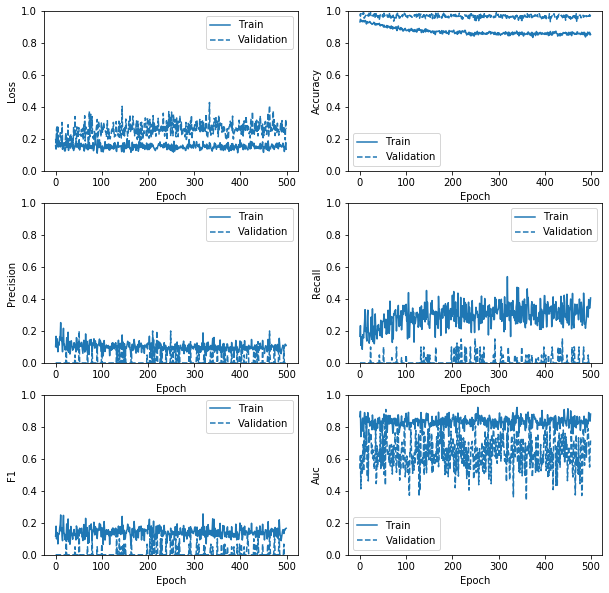

In [34]:
plt.figure(figsize=(10,10))
plot_metrics(imb_history)

## Evaluation

In [35]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 21s 210ms/step


In [36]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.546 :   0.271
Accuracy : 0.733 :   0.970
Precision : 0.032 :   0.025
Recall : 0.217 :   0.023
F1 : 0.054 :   0.022
AUC : 0.628 :   0.633


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [37]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1038.23676943779, 201.33030104637146)

In [38]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [39]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [40]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

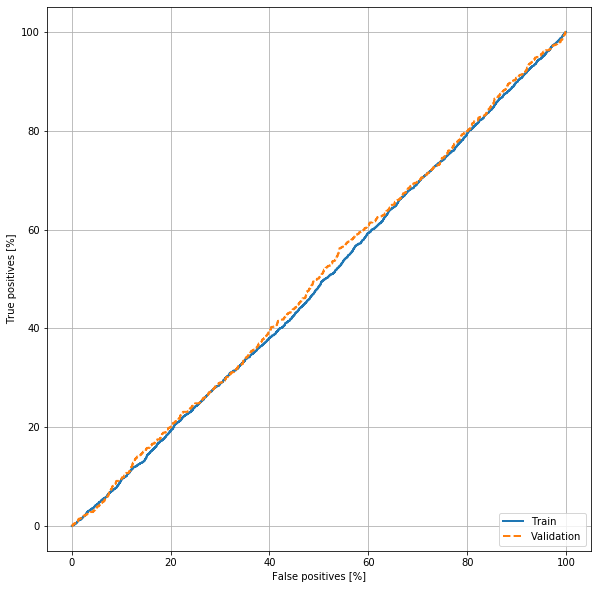

In [41]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 73064 
FP: 26391 
FN: 1772 
TP: 607
Healthy Patients - correctly identified (True Negatives):  73064 0.7346438087577296
Healthy Patients - predicted to have glaucoma (False Positives):  26391 0.2653561912422704
Glaucoma Patients - predicted healthy (False Negatives):  1772 0.7448507776376628
Glaucoma Patients - correctly identified (True Positives):  607 0.2551492223623371

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


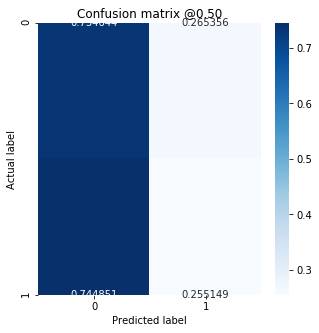

In [42]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 32784 
FP: 350 
FN: 802 
TP: 7
Healthy Patients - correctly identified (True Negatives):  32784 0.9894368322568963
Healthy Patients - predicted to have glaucoma (False Positives):  350 0.01056316774310376
Glaucoma Patients - predicted healthy (False Negatives):  802 0.9913473423980222
Glaucoma Patients - correctly identified (True Positives):  7 0.00865265760197775

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


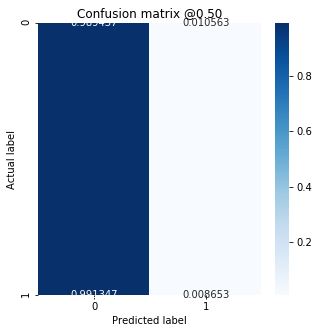

In [43]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [44]:
# history = up3_history
# tag_value = "trained twice bal and 1:20 and 1:40 with 78 tr layers with cw 0.5:3 and 0.2:5"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

In [45]:
# client = MlflowClient()
# run = client.create_run('21')
# client.set_tag(run.info.run_id, "tag_key", tag_value)